# Let's make fake galaxies!

(Zach Pace, UWisc; last substantial update 2 Sept 2016)

![badge-img](https://img.shields.io/badge/Made%20at-%23AstroHackWeek-8063d5.svg?style=flat)

Let's say you want to test your spectral fitting model... First, generate a CSP spectrum with a known SFH (and therefore, a known MWA). I'm using BC03. We can read in that spectrum, and fill an entire IFU with that spectrum, subject to some noise. We then feed that IFU into our spectral fitting model, and see how well the inference works at various levels of noise. 

`zaphod` giveth confidence, and `zaphod` taketh confidence away.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits
from astropy import units as u

Start by reading in a SFH, the resulting log-wavelength & spectrum, and the instrument's spectral covariance matrix...

In [2]:
import sys
if '../../stellarmass_pca/' not in sys.path:
    sys.path.append('../../stellarmass_pca/')
print(sys.path[-1])
# this is where all my SP fitting code lives

from find_pcs import *
import find_pcs
reload(find_pcs)

import cPickle as pkl

../../stellarmass_pca/


ImportError: No module named 'pywcsgrid2'

In [4]:
pca = pkl.load(open('../../stellarmass_pca/pca.pkl', 'r'))

In [5]:
i = 55 # pick a SFH
sfh_spec = pca.trn_spectra[i]
sfh_logl = pca.logl

spec_cov = np.load('bc03/manga_cov_for_model.npy')

In [6]:
param = 'MWA' # pick a parameter to focus on
param_real = pca.metadata[param][i]
print param, param_real

MWA 3.29826


In [7]:
import fake
reload(fake)

<module 'fake' from 'fake.pyc'>

Instantiate a `FakeIFU` object, with the parameters you're trying to fit for. Also note that we've supplied a spectral covariance matrix (but you could give a constant or a 1d array, and a multivariate---but non-covariate---matrix would be constructed for you). Also, it's almost certain that you don't know your actual spectral covariance, but how bad it really is depends on how careful your spectrophotometric calibration is. This is a can of worms.

In [17]:
fake_ifu = fake.FakeIFU.SingleSFH(
    logl=sfh_logl, dlogl=1.0e-4, spec=sfh_spec, 
    true_params=[param_real], param_names=[param],
    F_max=500, K=spec_cov, SNmax=60.)

Now make an artificial cube, with the given covariate noise, all built around a single SFH, but with a variety of amplitudes

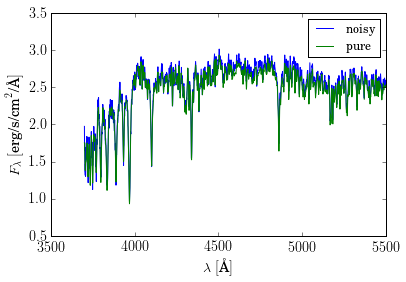

In [29]:
cube = fake_ifu.make_datacube()
plt.plot(10.**sfh_logl, cube[:, 37, 37], label='noisy')
plt.plot(10.**sfh_logl, fake_ifu.true_spectra[:, 37, 37], label='pure')
plt.legend(loc='best')
plt.xlabel(r'$\lambda~[\textrm{\AA}]$')
plt.ylabel(r'$F_{\lambda}~[\textrm{erg/s/cm}^2\textrm{/\AA}]$')
plt.show()

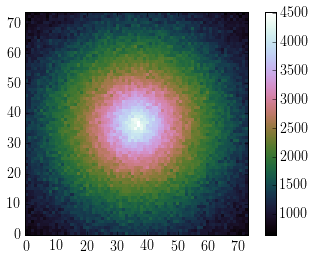

In [19]:
dlogl = 1.0e-4
l_l = 10.**(fake_ifu.logl - dlogl/2.)
l_u = 10.**(fake_ifu.logl + dlogl/2.)
dl = l_u - l_l
plt.imshow(
    (cube * dl[..., None, None]).sum(axis=0),
    aspect='equal')
plt.colorbar()
plt.show()

#Now let's test my PCA SP fitter

I wrote a stellar populations fitting library in summer 2016, which uses Principal Component Analysis to perform dimensionality reduction on a library of over ten-thousand spectra (which have values for properties like stellar metallicity, optical depth of absorbing dust clouds, and stellar mass-to-light ratio precomputed). This allows us to infer those properties for spectra that have been observed. The whole process runs much faster than traditional template-weighting (and "discovers" what spectral features are important for inferring what parameters), but its accuracy is not well-known. I want to test the outputs of this library on lots of fake (but noisified) IFUs, which have known underlying parameters. If the PCA SP fitting breaks in certain use-cases, this is a good way to discover that.

For more details on the fitting method, see [Chen et al. (2012)](http://adsabs.harvard.edu/abs/2012MNRAS.421..314C) and an upcoming paper by me.

Here's some prep for my spectral fits. Ignore this.

In [20]:
from cov_obs import *
import cPickle as pkl
from astropy.cosmology import WMAP9 as cosmo
cov = Cov_Obs(
    cov=fake_ifu.K, lllim=10.**sfh_logl[0],
    dlogl=1.0e-4, nobj=0, SB_r_mean=0.)

Instantiate an object to perform all the computation of _supposed_ best-fit underlying parameters by the PCA model.

In [21]:
pca_res = find_pcs.Test_PCA_Result(
    pca=pca, K_obs=cov, cosmo=cosmo, fake_ifu=fake_ifu,
    objname = 'FAKE')

We now have all the model weights available to us, so we can examine each parameter's fits one at a time! No need to re-instantiate the object, just call `pca_res.pca.param_pct_map()` again with a different `param` argument.

In [22]:
param_fit = pca_res.pca.param_pct_map(
    param, pca_res.w, [50.])[0, ...]

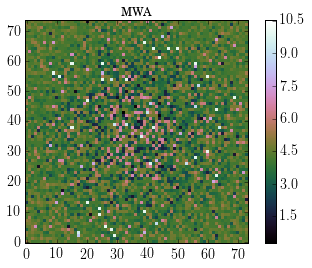

In [25]:
plt.imshow(param_fit, aspect='equal')
plt.colorbar()
plt.title(param)
plt.show()

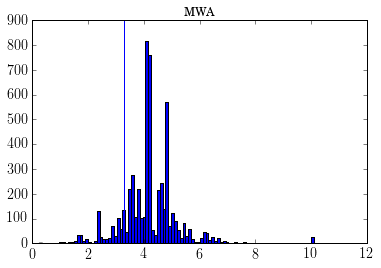

In [26]:
plt.hist(param_fit.flatten(), 100)
plt.title(param)
plt.axvline(param_real)